*First compiled: May 2, 2017.*

# Graph abstraction for data of [Paul *et al.*, Cell (2015)](https://doi.org/10.1016/j.cell.2015.11.013)

Here, we trace myeloid differentiation.

In [1]:
import numpy as np
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc

sc.settings.verbosity = 3                # amount of output
sc.settings.set_dpi(80)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy version 0.2.8+15.gfc4c1f4.dirty on 2017-09-18 22:06.


### Preprocessing

In [2]:
adata = sc.examples.paul15_raw()
sc.write('paul15_raw', adata)
sc.pp.recipe_zheng17(adata, plot=False)
sc.write('paul15', adata)

reading sheet data.debatched from file data/paul15/paul15.h5
reading sheet cluster.id from file data/paul15/paul15.h5
reading sheet info.genes_strings from file data/paul15/paul15.h5
writing ./write/paul15_raw.h5
normalizing by total count per cell
    finished (0:00:00.110) normalized adata.X and added
    "n_counts_all", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.058)
normalizing by total count per cell
    finished (0:00:00.019) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)
writing ./write/paul15.h5


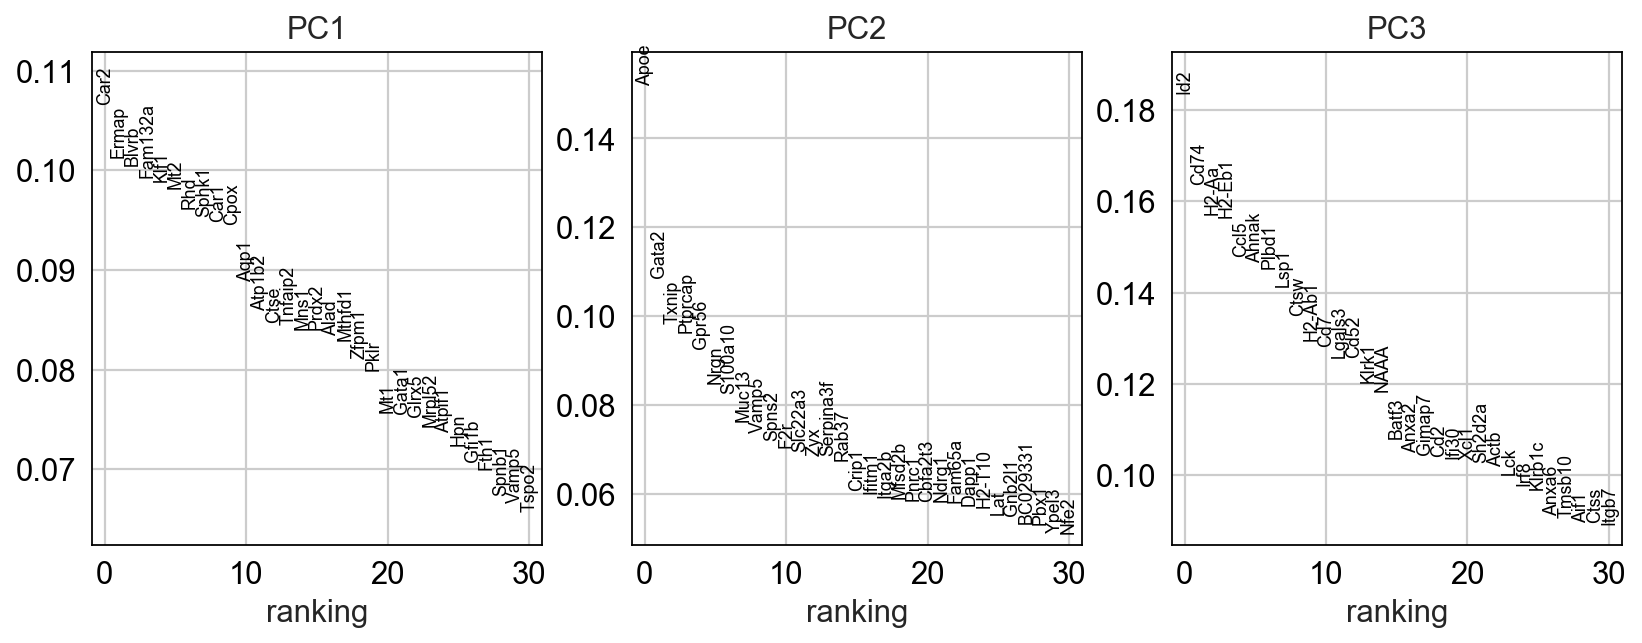

In [3]:
sc.tl.pca(adata)
sc.pl.pca_loadings(adata)

## Visualization

In [4]:
adata = sc.read('paul15')
sc.tl.tsne(adata, n_pcs=30)
sc.write('paul15', adata)

reading file ./write/paul15.h5
computing tSNE
    preprocess using PCA with 30 PCs
--> avoid this by setting n_pcs = 0
    using 30 principal components
    using the "MulticoreTSNE" package by Ulyanov (2017)
    finished (0:00:08.053) and added
    "X_tsne", tSNE coordinates (adata.smp)
writing ./write/paul15.h5


reading file ./write/paul15.h5
... you are using a very low resolution for saving figures, adjusting to dpi=300
... saving figure to file ./figures/tsne.png


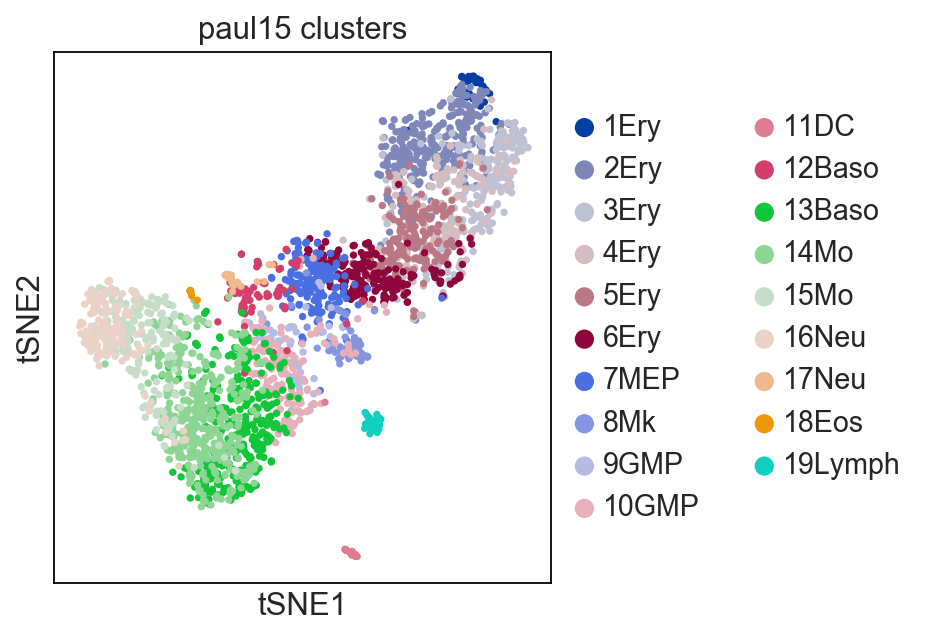

In [5]:
adata = sc.read('paul15')
ax = sc.pl.tsne(adata, color='paul15_clusters', palette=sc.pl.palettes.default_26,
                save=True, show=True, right_margin=0.8)

Let us also visualize the data using the Fruchterman-Reingold algorithm.

In [6]:
adata = sc.read('paul15')
sc.tl.draw_graph(adata, n_neighbors=4, recompute_graph=True)
sc.write('paul15', adata)

reading file ./write/paul15.h5
drawing single-cell graph using layout "fr"
    compute "X_pca" for building graph
    computing data graph with n_neighbors = 4 
    computing spectral decomposition ("diffmap") with 15 components
    eigenvalues of transition matrix
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.9781615734  0.9748940468  0.9719734192  0.9651904702
      0.9590314627  0.952006042   0.9453957081  0.9388744831  0.9358919263]
    finished (0:00:48.880) and added
    "X_draw_graph_fr", graph_drawing coordinates (adata.smp)
    "draw_graph_layout", the chosen layout (adata.add)
writing ./write/paul15.h5


... saving figure to file ./figures/draw_graph_fr.png


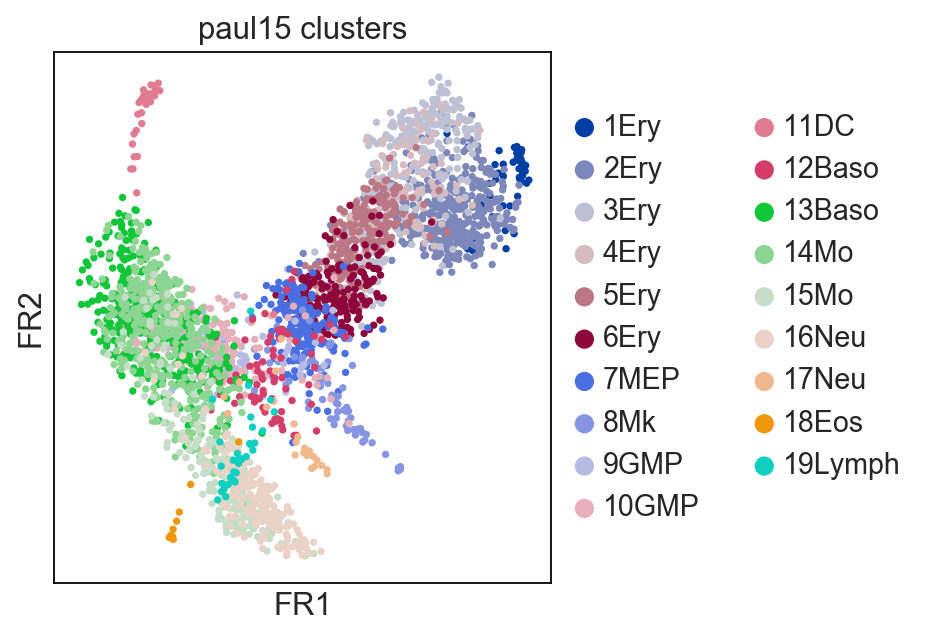

In [7]:
ax = sc.pl.draw_graph(adata, color='paul15_clusters', palette=sc.pl.palettes.default_26,
                      save=True, show=True, right_margin=0.8)

Apparently, using the default settings, FR resolves the heterogeneity nicer than tSNE.

### Inferring the differentiation tree using graph abstraction

In [8]:
adata = sc.read('paul15')
adata.add['iroot'] = np.flatnonzero(adata.smp['paul15_clusters']  == '7MEP')[0]
sc.tl.aga(adata,
          tree_detection='greedy_extremes',
          n_neighbors=4,
          resolution=1.2)
sc.write('paul15', adata)

reading file ./write/paul15.h5
running Louvain clustering
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.9781615734  0.9748940468  0.9719734192  0.9651904702]
    using the "louvain" package of Traag (2017)
    finished (0:00:00.215) and found 16 clusters, added
    "louvain_groups", the cluster labels (adata.smp)
    "louvain_groups_order", the unique cluster labels (adata.add)
running Approximate Graph Abstraction (AGA)
    using "X_pca" for building graph
    using stored data graph with n_neighbors = 4 and spectrum
    [ 1.            0.9966393709  0.9943132997  0.9864672422  0.981000483
      0.9788661599  0.9781615734  0.9748940468  0.9719734192  0.9651904702]
    abstracted graph will have 16 nodes
... finished (0:00:00.726) --> added
    aga_adjacency_full_attachedness : np.ndarray in adata.add
        The full adjacency matrix of t

reading file ./write/paul15.h5
... saving figure to file ./figures/aga.png


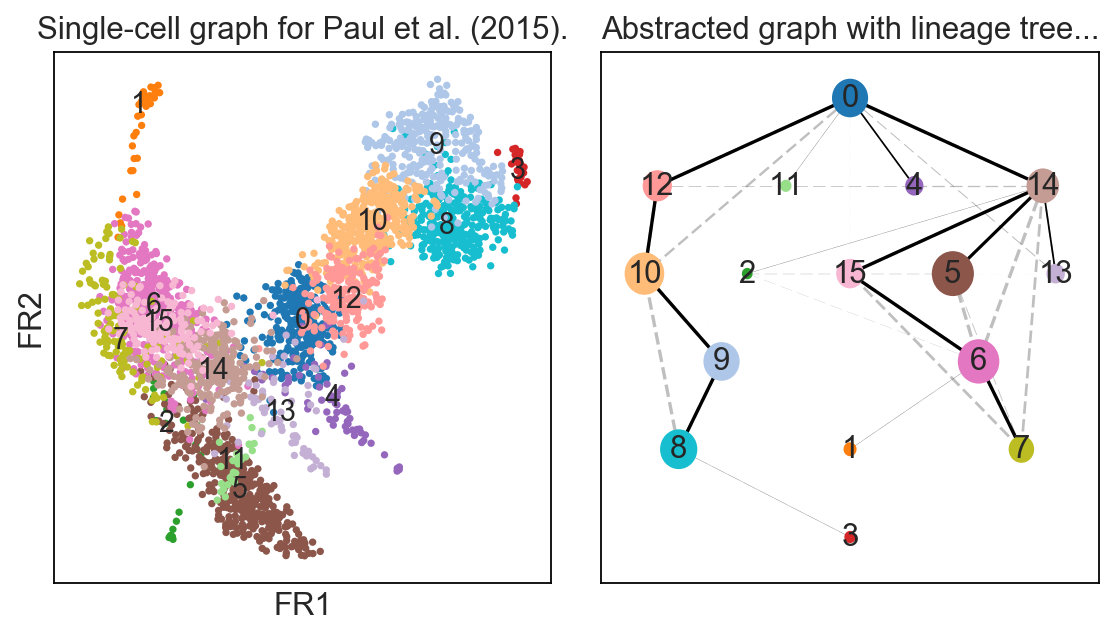

In [11]:
adata = sc.read('paul15')
axs = sc.pl.aga(adata, title=r'Single-cell graph for Paul et al. (2015).',
          title_graph='Abstracted graph with lineage tree...',
          basis='draw_graph_fr',
          root=0, color='aga_groups', groups_graph='aga_groups', layout='eq_tree', frameon=True,
          save=True, show=True)

... saving figure to file ./figures/aga_graph.png


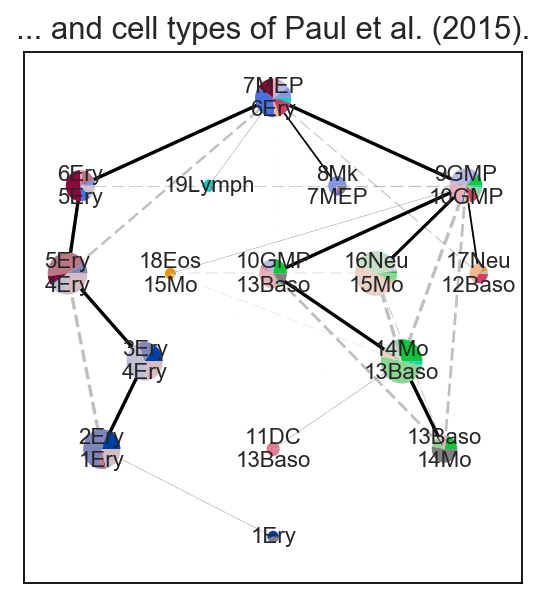

In [10]:
asso_names, asso_matrix = sc.utils.compute_association_matrix_of_groups(
    adata, prediction='aga_groups', reference='paul15_clusters', normalization='reference')
asso_colors = sc.utils.get_associated_colors_of_groups(sc.pl.palettes.default_26, asso_matrix)
ax = sc.pl.aga_graph(adata,
                     title='... and cell types of Paul et al. (2015).',
                     root=0, layout='eq_tree', frameon=True,
                     color=asso_colors, groups=asso_names,
                     fontsize=10, save=True, show=True)

### Reconstruct dynamics for a given set of genes

Reconstruct the dynamics.

In [25]:
adata_all_genes = sc.examples.paul15_raw()
sc.pp.recipe_zheng17(adata_all_genes, n_top_genes=3000)
adata_all_genes.smp['aga_groups'] = adata.smp['aga_groups']
adata_all_genes.smp['aga_pseudotime'] = adata.smp['aga_pseudotime']

reading sheet data.debatched from file data/paul15/paul15.h5
reading sheet cluster.id from file data/paul15/paul15.h5
reading sheet info.genes_strings from file data/paul15/paul15.h5
normalizing by total count per cell
    finished (0:00:00.079) normalized adata.X and added
    "n_counts_all", counts per cell before normalization (adata.smp)
filter highly varying genes by dispersion and mean (0:00:00.049)
normalizing by total count per cell
    finished (0:00:00.055) normalized adata.X and added
    "n_counts", counts per cell before normalization (adata.smp)


In [26]:
gene_names = ['Gata2', 'Gata1', 'Hba-a2', 'Gfi1', 'Elane', 'Irf8', 'Csf1r']

reading file ./write/paul15.h5


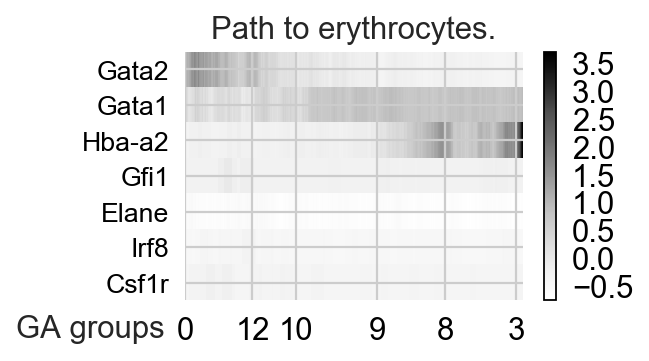

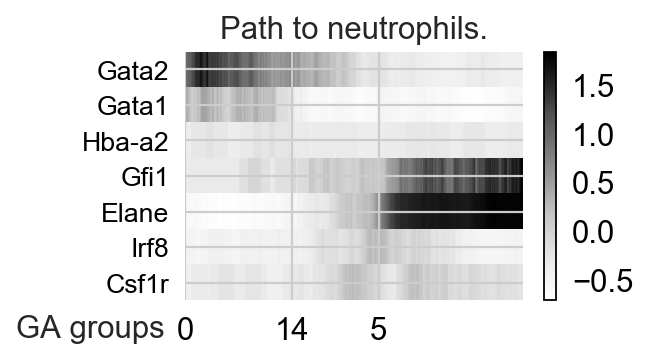

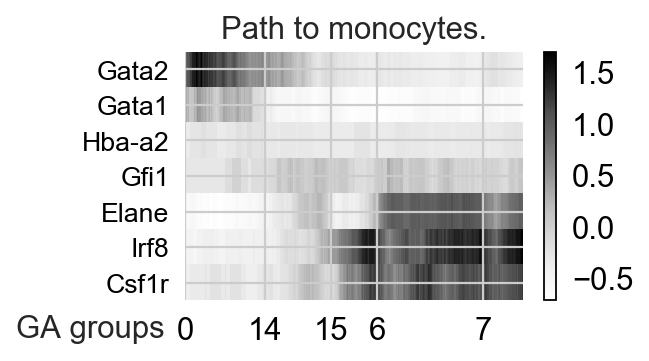

In [50]:
adata = sc.read('paul15')
paths = [('erythrocytes', [0, 12, 10, 9, 8, 3]), 
         ('neutrophils', [0, 14, 5]), 
         ('monocytes', [0, 14, 15, 6, 7])]
rcParams['figure.figsize'] = (4, 2.16)
rcParams['figure.subplot.top'] = 0.85
rcParams['figure.subplot.bottom'] = 0.13
for ipath, (descr, path) in enumerate(paths):
    ax = sc.pl.aga_path(adata_all_genes, left_margin=0.3,
                        nodes=path,
                        ytick_fontsize=12,
                        keys=gene_names,
                        n_avg=50,
                        title='Path to {}.'.format(descr),
                        normalize_to_zero_one=False, show=False)
    ax.text(-0.5, -0.15, 'GA groups', transform=ax.transAxes)
    ax.set_xlabel('')
    pl.savefig('./figures/aga_path_{}.png'.format(descr))
    pl.show()
sc.pl.reset_rcParams()